In [1]:
import pandas as pd
import numpy as np
data_path = '/opt/data'
train_user_info = pd.read_csv(data_path+'/tc/train_user_info.csv')
test_user_info = pd.read_csv(data_path+'/tc/test_user_info.csv')
train_shop_info = pd.read_csv(data_path+'/tc/train_shop_info.csv')
test_shop_info = pd.read_csv(data_path+'/tc/test_shop_info.csv')
train_context= pd.read_csv(data_path+'/tc/train_context.csv')
test_context = pd.read_csv(data_path+'/tc/test_context.csv')
train_context['cos'] = np.load(data_path+'/tc/cos_x.npy')
test_context['cos'] = np.load(data_path+'/tc/cos_test_x.npy')

In [2]:
Y = pd.read_csv(data_path+'/tc/train_data.csv')['label']

In [3]:
train_data = pd.concat([train_context,Y],axis = 1)

In [4]:
train_data[['用户ID','门店ID','请求类目ID']] = train_data[['用户ID','门店ID','请求类目ID']].fillna(0).astype('int')
test_context[['用户ID','门店ID','请求类目ID']] = test_context[['用户ID','门店ID','请求类目ID']].fillna(0).astype('int')

In [5]:
from sklearn.decomposition import PCA
import numpy as np
user_fir = ['用户ID', '性别', '年龄', '职业']
user_se = ['cnt_total_click', 'cnt_recent_click',
       'flag_total_click', 'flag_recent_click', 'cnt_total_click_days',
       'cnt_recent_click_days', 'cnt_total_click_poi', 'cnt_recent_click_poi']
# Try to decrease the feature nums for both users and merchants
user_pca = PCA(n_components=1, whiten = True)

train_user_part = pd.concat([train_user_info[user_fir].astype('int'),
                            pd.DataFrame(user_pca.fit_transform(train_user_info[user_se]),columns=['user_pca1'])],
                            axis = 1)
test_user_part = pd.concat([test_user_info[user_fir].astype('int'),
                            pd.DataFrame(user_pca.transform(test_user_info[user_se]),columns=['user_pca1'])],
                            axis = 1)

In [6]:
shop_fir = ['门店ID', '门店一级类目', '门店二级类目', '门店三级类目', '门店商圈', '平均分数','price']
shop_se = ['all_expose',
       'all_click', 'fir_category_price_diff', 'sec_category_price_diff',
       'thi_category_price_diff', 'mall_price_diff', 'fir_category_score_diff',
       'sec_category_score_diff', 'thi_category_score_diff', 'mall_score_diff',
       'recent_expose', 'recent_click', ]
shop_pca = PCA(n_components=1,whiten = True)

train_shop_part = pd.concat([train_shop_info[shop_fir].fillna(0).astype('int'),
                            pd.DataFrame(shop_pca.fit_transform(train_shop_info[shop_se]),columns=['shop_pca1'])],
                            axis = 1)
test_shop_part = pd.concat([test_shop_info[shop_fir].fillna(0).astype('int'),
                            pd.DataFrame(shop_pca.transform(test_shop_info[shop_se]),columns=['shop_pca1'])],
                            axis = 1)

In [7]:
import datetime
# train_target = train_data.groupby('用户ID').apply(lambda t: t[(t["日期"] == t["日期"].max())|(t["日期"] == t["日期"].max()-datetime.timedelta(1))])
def in_train(x):
    if x in ['2022-08-23',
 '2022-08-24',
 '2022-08-25',
 '2022-08-26',
 '2022-08-27',
 '2022-08-28',
 '2022-08-29']:
        return True
    else:
        return False
# divide into trainset and testset
train_target = train_data[train_data['日期'].apply(in_train)]

In [8]:
# train_target_index = train_target.index.levels[1]
# trainset with positive labels
train_target_index = train_target.index
pos_his = train_data[(~train_data.index.isin(train_target_index))&train_data['label']==1]
pos_his = pos_his.merge(train_shop_part,how='left',on ='门店ID')
train_group = pos_his.sort_values(by=["日期"]).groupby("用户ID")

train_history_data = pd.DataFrame(
    data={
        "user_id": list(train_group.groups.keys()),
        "shop_ids": list(train_group['门店ID'].apply(list)),
        "request_cate_ids": list(train_group['请求类目ID'].apply(list)),
        "fir_ids": list(train_group['门店一级类目'].apply(list)),
        "sec_ids": list(train_group['门店二级类目'].apply(list)),
        "thr_ids": list(train_group['门店三级类目'].apply(list)),
        "mall_ids": list(train_group['门店商圈'].apply(list)),
        "his_score": list(train_group['平均分数'].apply(list)),
        "his_price": list(train_group['price'].apply(list)),
        "his_shop_pca": list(train_group['shop_pca1'].apply(list)),
        # "date": list(train_group['日期'].apply(list)),
    }
)


In [9]:
# using behavior_len to represent the valid id length for merchants
train_history_data['behavior_len'] = train_history_data["shop_ids"].apply(lambda x : len(x))

In [10]:
# trainset with negative labels
neg_his = train_data[(~train_data.index.isin(train_target_index))&train_data['label']==0]
neg_his = neg_his.merge(train_shop_part,how='left',on ='门店ID')
train_neg_group = neg_his.sort_values(by=["日期"]).groupby("用户ID")

train_neg_history_data = pd.DataFrame(
    data={
        "user_id": list(train_neg_group.groups.keys()),
        "neg_shop_ids": list(train_neg_group['门店ID'].apply(list)),
        "neg_request_cate_ids": list(train_neg_group['请求类目ID'].apply(list)),
        "neg_fir_ids": list(train_neg_group['门店一级类目'].apply(list)),
        "neg_sec_ids": list(train_neg_group['门店二级类目'].apply(list)),
        "neg_thr_ids": list(train_neg_group['门店三级类目'].apply(list)),
        "neg_mall_ids": list(train_neg_group['门店商圈'].apply(list)),
        "neg_his_score": list(train_neg_group['平均分数'].apply(list)),
        "neg_his_price": list(train_neg_group['price'].apply(list)),
        "neg_his_shop_pca": list(train_neg_group['shop_pca1'].apply(list)),
        # "date": list(train_group['日期'].apply(list)),
    }
)
train_neg_history_data['neg_behavior_len'] = train_neg_history_data['neg_shop_ids'].apply(lambda x : len(x))

In [11]:

length = 10
def complement(ll):
    if len(ll) >=length:
        return ll[-1*length:]
    else:
        return ll+[0,]*(length-len(ll))
# if the original length is not enough, complementing using 0
train_history_data[['shop_ids', 'request_cate_ids', 'fir_ids', 'sec_ids',
       'thr_ids', 'mall_ids', 'his_score', 'his_price', 'his_shop_pca']] = train_history_data[['shop_ids', 'request_cate_ids', 'fir_ids', 'sec_ids',
       'thr_ids', 'mall_ids', 'his_score', 'his_price', 'his_shop_pca']].applymap(complement)
train_history_data['behavior_len'] = train_history_data["behavior_len"].apply(lambda x : length if x>length else x)
train_neg_history_data[['neg_shop_ids', 'neg_request_cate_ids', 'neg_fir_ids', 'neg_sec_ids',
       'neg_thr_ids', 'neg_mall_ids', 'neg_his_score', 'neg_his_price', 'neg_his_shop_pca']] = train_neg_history_data[['neg_shop_ids', 'neg_request_cate_ids', 'neg_fir_ids', 'neg_sec_ids',
       'neg_thr_ids', 'neg_mall_ids', 'neg_his_score', 'neg_his_price', 'neg_his_shop_pca']].applymap(complement)
train_neg_history_data['neg_behavior_len'] = train_neg_history_data["neg_behavior_len"].apply(lambda x : length if x>length else x)

In [12]:
# train_all_data = train_target.drop('用户ID',axis=1).reset_index().drop('level_1',axis=1).merge(train_user_part,how='left',on='用户ID')
# put all the train features together
train_all_data = train_target.reset_index().merge(train_user_part,how='left',on='用户ID')
train_all_data = train_all_data.merge(train_shop_part,how='left',on='门店ID')
train_all_data = train_all_data.merge(train_history_data,how='left',left_on='用户ID',right_on = 'user_id')
train_all_data = train_all_data.drop('user_id',axis=1)
train_all_data = train_all_data.merge(train_neg_history_data,how='left',left_on='用户ID',right_on = 'user_id')

In [13]:
def fill(x):
    if x is np.nan:
        return [0,]*length
    else:
        return x
train_all_data[['shop_ids', 'request_cate_ids',
       'fir_ids', 'sec_ids', 'thr_ids', 'mall_ids', 'his_score', 'his_price',
       'his_shop_pca','neg_shop_ids', 'neg_request_cate_ids', 'neg_fir_ids', 'neg_sec_ids',
       'neg_thr_ids', 'neg_mall_ids', 'neg_his_score', 'neg_his_price', 'neg_his_shop_pca']] = train_all_data[['shop_ids', 'request_cate_ids',
       'fir_ids', 'sec_ids', 'thr_ids', 'mall_ids', 'his_score', 'his_price',
       'his_shop_pca','neg_shop_ids', 'neg_request_cate_ids', 'neg_fir_ids', 'neg_sec_ids',
       'neg_thr_ids', 'neg_mall_ids', 'neg_his_score', 'neg_his_price', 'neg_his_shop_pca']].applymap(fill)
train_all_data[['behavior_len','neg_behavior_len']] = train_all_data[['behavior_len','neg_behavior_len']].fillna(0)
train_all_data['user_id'] = train_all_data['user_id'].fillna(0)

Text(0.5, 1.0, 'sample distribution')

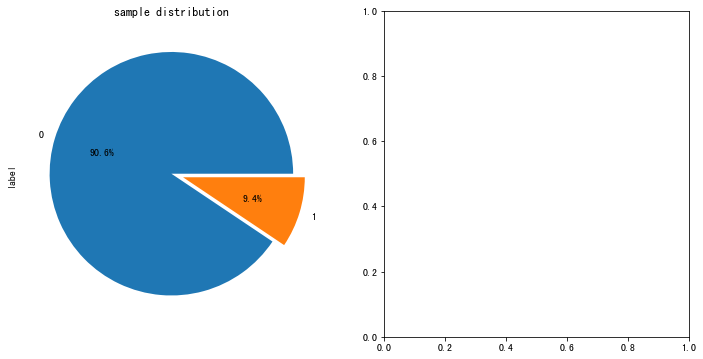

In [23]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2,figsize=(12,6))
train_all_data['label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=axes[0])
axes[0].set_title('sample distribution')

In [14]:
# Because of imbalance of the sample, increase the negative sample proportion
t_index_t = train_all_data[train_all_data['label'] == 1].index
t_index_n = train_all_data[train_all_data['label'] == 0].sample(3*len(t_index_t)).index
t_index = list(t_index_t)+list(t_index_n)
resample = train_all_data.iloc[t_index,:]

In [15]:
from sklearn.utils import shuffle
resample = shuffle(resample)
resample['label']

5406716    0
4985946    1
7960712    1
4658584    1
7168959    0
          ..
6451636    0
841912     1
6204947    0
2733411    0
2457652    1
Name: label, Length: 3002840, dtype: int64

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp

# using focalloss to stress the negative sample, used for imblance problem
class FocalLoss(nn.Module):

    def __init__(self,
                 alpha=0.9,
                 gamma=2,
                 reduction='mean',):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.crit = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, label, reduction = 'mean'):
        self.reduction = reduction
        '''
        Usage is same as nn.BCEWithLogits:
            >>> criteria = FocalLossV1()
            >>> logits = torch.randn(8, 19, 384, 384)
            >>> lbs = torch.randint(0, 2, (8, 19, 384, 384)).float()
            >>> loss = criteria(logits, lbs)
        '''
        probs = torch.sigmoid(logits)
        coeff = torch.abs(label - probs).pow(self.gamma).neg()
        log_probs = torch.where(logits >= 0,
                F.softplus(logits, -1, 50),
                logits - F.softplus(logits, 1, 50))
        log_1_probs = torch.where(logits >= 0,
                -logits + F.softplus(logits, -1, 50),
                -F.softplus(logits, 1, 50))
        loss = label * self.alpha * log_probs + (1. - label) * (1. - self.alpha) * log_1_probs
        loss = loss * coeff

        if self.reduction == 'mean':
            loss = loss.mean()
        if self.reduction == 'sum':
            loss = loss.sum()
        return loss
    
def get_image_count_frequency(version="v0_5"):
    if version == "v0_5":
        from mmdet.utils.lvis_v0_5_categories import get_image_count_frequency
        return get_image_count_frequency()
    elif version == "v1":
        from mmdet.utils.lvis_v1_0_categories import get_image_count_frequency
        return get_image_count_frequency()
    elif version == "openimage":
        from mmdet.utils.openimage_categories import get_instance_count
        return get_instance_count()
    else:
        raise KeyError(f"version {version} is not supported")

class EQL(nn.Module):
    def __init__(self,
                 use_sigmoid=True,
                 reduction='mean',
                 class_weight=None,
                 loss_weight=1.0,
                 lambda_=0.00177,
                 version="v0_5"):
        super(EQL, self).__init__()
        self.use_sigmoid = use_sigmoid
        self.reduction = reduction
        self.loss_weight = loss_weight
        self.class_weight = class_weight
        self.lambda_ = lambda_
        self.version = version
        self.freq_info = torch.FloatTensor(get_image_count_frequency(version))

        num_class_included = torch.sum(self.freq_info < self.lambda_)
        print(f"set up EQL (version {version}), {num_class_included} classes included.")

    def forward(self,
                cls_score,
                label,
                weight=None,
                avg_factor=None,
                reduction_override=None,
                **kwargs):
        self.n_i, self.n_c = cls_score.size()

        self.gt_classes = label
        self.pred_class_logits = cls_score

        def expand_label(pred, gt_classes):
            target = pred.new_zeros(self.n_i, self.n_c + 1)
            target[torch.arange(self.n_i), gt_classes] = 1
            return target[:, :self.n_c]

        target = expand_label(cls_score, label)

        eql_w = 1 - self.exclude_func() * self.threshold_func() * (1 - target)

        cls_loss = F.binary_cross_entropy_with_logits(cls_score, target,
                                                      reduction='none')

        cls_loss = torch.sum(cls_loss * eql_w) / self.n_i

        return self.loss_weight * cls_loss

    def exclude_func(self):
        # instance-level weight
        bg_ind = self.n_c
        weight = (self.gt_classes != bg_ind).float()
        weight = weight.view(self.n_i, 1).expand(self.n_i, self.n_c)
        return weight

    def threshold_func(self):
        # class-level weight
        weight = self.pred_class_logits.new_zeros(self.n_c)
        weight[self.freq_info < self.lambda_] = 1
        weight = weight.view(1, self.n_c).expand(self.n_i, self.n_c)
        return weight

In [17]:
import numpy as np
import torch

from deepctr_torch.inputs import SparseFeat, DenseFeat, VarLenSparseFeat, get_feature_names
from deepctr_torch.models import DIEN,DIN
# from ainputs import VarLenDenseFeat

length = 10
# SparseFeat used for nominal feature, DenseFeat used for numerical feature
def get_xy_fd(train_all_data,use_neg=False, hash_flag=False):
    feature_columns = [SparseFeat('user', max(test_user_part['用户ID'].max(),train_user_part['用户ID'].max())+1, embedding_dim=8, use_hash=hash_flag),
                       SparseFeat('gender', 4, embedding_dim=4, use_hash=hash_flag),
                       SparseFeat('occupation', train_user_part['职业'].max()+1, embedding_dim=4, use_hash=hash_flag),
                       SparseFeat('shop_id', max(test_shop_part['门店ID'].max(),train_shop_part['门店ID'].max()) + 1, embedding_dim=8, use_hash=hash_flag),
                       SparseFeat('request_cate_id',  max(test_context['请求类目ID'].max(),train_context['请求类目ID'].max()) + 1, embedding_dim=4, use_hash=hash_flag),
                       SparseFeat('cate_fir_id', max(test_shop_part['门店一级类目'].max(),train_shop_part['门店一级类目'].max()) + 1, embedding_dim=2, use_hash=hash_flag),
                       SparseFeat('cate_sec_id', max(test_shop_part['门店二级类目'].max(),train_shop_part['门店二级类目'].max()) + 1, embedding_dim=4, use_hash=hash_flag),
                       SparseFeat('cate_thr_id', max(test_shop_part['门店三级类目'].max(),train_shop_part['门店三级类目'].max()) + 1, embedding_dim=4, use_hash=hash_flag),
                       SparseFeat('mall_id', max(test_shop_part['门店商圈'].max(),train_shop_part['门店商圈'].max()) + 1, embedding_dim=4, use_hash=hash_flag),
                       DenseFeat('age', 1),
                      DenseFeat('user_pca1', 1),
                      DenseFeat('dis', 1),
                      DenseFeat('score', 1),
                      DenseFeat('price', 1),
                      DenseFeat('shop_pca1', 1),
                      DenseFeat('cos', 1)]

    feature_columns += [
        VarLenSparseFeat(SparseFeat('hist_shop_id', vocabulary_size=max(test_shop_part['门店ID'].max(),train_shop_part['门店ID'].max()) + 1, embedding_dim=8, embedding_name='shop_id'),
                         maxlen=length, length_name="seq_length"),
        VarLenSparseFeat(SparseFeat('hist_request_cate_id', vocabulary_size=max(test_context['请求类目ID'].max(),train_context['请求类目ID'].max()) + 1, embedding_dim=4, embedding_name='request_cate_id'),
                         maxlen=length,
                         length_name="seq_length"),
        VarLenSparseFeat(SparseFeat('hist_cate_fir_id', vocabulary_size=max(test_shop_part['门店一级类目'].max(),train_shop_part['门店一级类目'].max()) + 1, embedding_dim=2, embedding_name='cate_fir_id'),
                         maxlen=length, length_name="seq_length"),
        VarLenSparseFeat(SparseFeat('hist_cate_sec_id', vocabulary_size=max(test_shop_part['门店二级类目'].max(),train_shop_part['门店二级类目'].max()) + 1, embedding_dim=4, embedding_name='cate_sec_id'),
                         maxlen=length,length_name="seq_length"),
        VarLenSparseFeat(SparseFeat('hist_cate_thr_id', vocabulary_size=max(test_shop_part['门店三级类目'].max(),train_shop_part['门店三级类目'].max())+ 1, embedding_dim=4, embedding_name='cate_thr_id'),
                         maxlen=length,length_name="seq_length"),
        VarLenSparseFeat(SparseFeat('hist_mall_id', vocabulary_size=max(test_shop_part['门店商圈'].max(),train_shop_part['门店商圈'].max()) + 1, embedding_dim=4, embedding_name='mall_id'),
                         maxlen=length,length_name="seq_length")]
        # VarLenDenseFeat(DenseFeat('his_score', 1),
        #                  maxlen=length,length_name="seq_length"),
        # VarLenDenseFeat(DenseFeat('his_price', 1),
        #                  maxlen=length,length_name="seq_length"),
        # VarLenDenseFeat(DenseFeat('his_shop_pca', 1),
        #                  maxlen=length,length_name="seq_length")

    behavior_feature_list = ["shop_id", 
                             'request_cate_id','cate_fir_id','cate_sec_id','cate_thr_id',
                            'mall_id']


                      
    feature_dict = {'user': train_all_data['用户ID'].values, 
                    'gender': train_all_data['性别'].values,
                    'occupation': train_all_data['职业'].values, 
                    'age':train_all_data['年龄'].values,
                    'cos':train_all_data['cos'].values,
                    'user_pca1':train_all_data['user_pca1'].values,'dis':train_all_data['dis'].values,
                    'score':train_all_data['平均分数'].values,'price':train_all_data['price'].values,
                    'shop_pca1':train_all_data['shop_pca1'].values,
                    'shop_id': train_all_data['门店ID'].values, 'request_cate_id': train_all_data['请求类目ID'].values,
                    'cate_fir_id':train_all_data['门店一级类目'].values,'cate_sec_id': train_all_data['门店二级类目'].values,
                    'cate_thr_id': train_all_data['门店三级类目'].values,'mall_id': train_all_data['门店商圈'].values,
                    'hist_shop_id':np.array(list(train_all_data['shop_ids'].values)),'hist_request_cate_id':np.array(list(train_all_data['request_cate_ids'].values)),
                    'hist_cate_fir_id':np.array(list(train_all_data['fir_ids'].values)),'hist_cate_sec_id':np.array(list(train_all_data['sec_ids'].values)),
                    'hist_cate_thr_id':np.array(list(train_all_data['thr_ids'].values)),'hist_mall_id':np.array(list(train_all_data['mall_ids'].values)),
                    # 'his_score':train_all_data['his_score'],'his_price':train_all_data['his_price'],
                    # 'his_shop_pca':train_all_data['his_shop_pca'], 
                    "seq_length": train_all_data['behavior_len'].values}
    

    if use_neg:
        feature_dict['neg_hist_shop_id'] = np.array(list(train_all_data['neg_shop_ids'].values))
        feature_dict['neg_hist_request_cate_id'] = np.array(list(train_all_data['neg_request_cate_ids'].values))
        feature_dict['neg_hist_cate_fir_id'] = np.array(list(train_all_data['neg_fir_ids'].values))
        feature_dict['neg_hist_cate_sec_id'] = np.array(list(train_all_data['sec_ids'].values))
        feature_dict['neg_hist_cate_thr_id'] = np.array(list(train_all_data['thr_ids'].values))
        feature_dict['neg_hist_mall_id'] = np.array(list(train_all_data['neg_mall_ids'].values))
        feature_dict['neg_seq_length'] = train_all_data['neg_behavior_len'].values
        feature_columns += [
        VarLenSparseFeat(SparseFeat('neg_hist_shop_id', vocabulary_size=max(test_shop_part['门店ID'].max(),train_shop_part['门店ID'].max()) + 1, embedding_dim=8, embedding_name='shop_id'),
                         maxlen=length, length_name="neg_seq_length"),
        VarLenSparseFeat(SparseFeat('neg_hist_request_cate_id', vocabulary_size=max(test_context['请求类目ID'].max(),train_context['请求类目ID'].max()) + 1, embedding_dim=4, embedding_name='request_cate_id'),
                         maxlen=length,
                         length_name="neg_seq_length"),
        VarLenSparseFeat(SparseFeat('neg_hist_cate_fir_id', vocabulary_size=max(test_shop_part['门店一级类目'].max(),train_shop_part['门店一级类目'].max()) + 1, embedding_dim=2, embedding_name='cate_fir_id'),
                         maxlen=length, length_name="neg_seq_length"),
        VarLenSparseFeat(SparseFeat('neg_hist_cate_sec_id', vocabulary_size=max(test_shop_part['门店二级类目'].max(),train_shop_part['门店二级类目'].max()) + 1, embedding_dim=4, embedding_name='cate_sec_id'),
                         maxlen=length,length_name="neg_seq_length"),
        VarLenSparseFeat(SparseFeat('neg_hist_cate_thr_id', vocabulary_size=max(test_shop_part['门店三级类目'].max(),train_shop_part['门店三级类目'].max())+ 1, embedding_dim=4, embedding_name='cate_thr_id'),
                         maxlen=length,length_name="neg_seq_length"),
        VarLenSparseFeat(SparseFeat('neg_hist_mall_id', vocabulary_size=max(test_shop_part['门店商圈'].max(),train_shop_part['门店商圈'].max()) + 1, embedding_dim=4, embedding_name='mall_id'),
                         maxlen=length,length_name="neg_seq_length")]

    x = {name: feature_dict[name] for name in get_feature_names(feature_columns)}
    
    # print(x)
    # print(feature_columns)
    y = train_all_data['label'].values
    return x, y, feature_columns, behavior_feature_list


if __name__ == "__main__":
    x, y, feature_columns, behavior_feature_list = get_xy_fd(resample, use_neg=True)
    
    device = 'cpu'
    use_cuda = True
    if use_cuda and torch.cuda.is_available():
        print('cuda ready...')
        device = 'cuda:0'
    torch.backends.cudnn.enabled = False
    
    model = DIEN(feature_columns, behavior_feature_list,
                 dnn_hidden_units=[128, 64], dnn_dropout=0.8, gru_type="AUGRU", use_negsampling=True, device=device)

    # model.compile('adam', 'binary_crossentropy',
    #               metrics=['binary_crossentropy', 'auc'])
    from torch.optim import Adam
    model.compile(Adam(model.parameters(), lr=0.001,weight_decay=1e-7), 'binary_crossentropy',
                  metrics=['binary_crossentropy', 'auc'])
    # model = DIN(feature_columns, behavior_feature_list, device=device, att_weight_normalization=True)
    # model.compile('adagrad', 'binary_crossentropy',
    #               metrics=['binary_crossentropy'])
    # model.train()
    history = model.fit(x, y, batch_size=5000, epochs=20, verbose=1, validation_split=0.2, shuffle=True)


cuda ready...


0it [00:00, ?it/s]

cuda:0
Train on 2402272 samples, validate on 600568 samples, 481 steps per epoch


481it [00:42, 11.43it/s]
1it [00:00,  5.32it/s]

Epoch 1/20
46s - loss:  0.5714 - binary_crossentropy:  0.5712 - auc:  0.5543 - val_binary_crossentropy:  0.5430 - val_auc:  0.6309


481it [00:41, 11.62it/s]
1it [00:00,  5.36it/s]

Epoch 2/20
47s - loss:  0.5232 - binary_crossentropy:  0.5231 - auc:  0.6893 - val_binary_crossentropy:  0.5329 - val_auc:  0.6621


481it [00:41, 11.62it/s]
1it [00:00,  5.12it/s]

Epoch 3/20
47s - loss:  0.4964 - binary_crossentropy:  0.4964 - auc:  0.7385 - val_binary_crossentropy:  0.5364 - val_auc:  0.6625


481it [00:41, 11.66it/s]
1it [00:00,  5.39it/s]

Epoch 4/20
47s - loss:  0.4828 - binary_crossentropy:  0.4827 - auc:  0.7566 - val_binary_crossentropy:  0.5406 - val_auc:  0.6614


481it [00:40, 11.75it/s]
1it [00:00,  5.21it/s]

Epoch 5/20
46s - loss:  0.4752 - binary_crossentropy:  0.4752 - auc:  0.7655 - val_binary_crossentropy:  0.5532 - val_auc:  0.6607


481it [00:40, 11.75it/s]
0it [00:00, ?it/s]

Epoch 6/20
45s - loss:  0.4699 - binary_crossentropy:  0.4698 - auc:  0.7713 - val_binary_crossentropy:  0.5534 - val_auc:  0.6610


481it [00:42, 11.28it/s]
1it [00:00,  5.46it/s]

Epoch 7/20
47s - loss:  0.4662 - binary_crossentropy:  0.4661 - auc:  0.7754 - val_binary_crossentropy:  0.5673 - val_auc:  0.6608


481it [00:41, 11.65it/s]
0it [00:00, ?it/s]

Epoch 8/20
46s - loss:  0.4628 - binary_crossentropy:  0.4627 - auc:  0.7790 - val_binary_crossentropy:  0.5647 - val_auc:  0.6577


481it [00:41, 11.67it/s]
1it [00:00,  5.22it/s]

Epoch 9/20
46s - loss:  0.4591 - binary_crossentropy:  0.4590 - auc:  0.7830 - val_binary_crossentropy:  0.5687 - val_auc:  0.6581


481it [00:41, 11.73it/s]
1it [00:00,  5.30it/s]

Epoch 10/20
46s - loss:  0.4558 - binary_crossentropy:  0.4558 - auc:  0.7873 - val_binary_crossentropy:  0.5824 - val_auc:  0.6574


481it [00:41, 11.71it/s]
0it [00:00, ?it/s]

Epoch 11/20
46s - loss:  0.4513 - binary_crossentropy:  0.4513 - auc:  0.7923 - val_binary_crossentropy:  0.5864 - val_auc:  0.6575


481it [00:41, 11.70it/s]
0it [00:00, ?it/s]

Epoch 12/20
45s - loss:  0.4476 - binary_crossentropy:  0.4476 - auc:  0.7973 - val_binary_crossentropy:  0.5796 - val_auc:  0.6559


481it [00:42, 11.40it/s]
0it [00:00, ?it/s]

Epoch 13/20
46s - loss:  0.4426 - binary_crossentropy:  0.4425 - auc:  0.8028 - val_binary_crossentropy:  0.5897 - val_auc:  0.6527


481it [00:41, 11.71it/s]
0it [00:00, ?it/s]

Epoch 14/20
46s - loss:  0.4386 - binary_crossentropy:  0.4386 - auc:  0.8078 - val_binary_crossentropy:  0.5960 - val_auc:  0.6527


481it [00:41, 11.56it/s]
1it [00:00,  5.16it/s]

Epoch 15/20
47s - loss:  0.4340 - binary_crossentropy:  0.4339 - auc:  0.8130 - val_binary_crossentropy:  0.6011 - val_auc:  0.6516


481it [00:41, 11.50it/s]
1it [00:00,  5.35it/s]

Epoch 16/20
47s - loss:  0.4299 - binary_crossentropy:  0.4298 - auc:  0.8177 - val_binary_crossentropy:  0.6129 - val_auc:  0.6502


481it [00:41, 11.64it/s]
0it [00:00, ?it/s]

Epoch 17/20
45s - loss:  0.4258 - binary_crossentropy:  0.4257 - auc:  0.8222 - val_binary_crossentropy:  0.6177 - val_auc:  0.6497


481it [00:42, 11.24it/s]
1it [00:00,  5.04it/s]

Epoch 18/20
47s - loss:  0.4217 - binary_crossentropy:  0.4217 - auc:  0.8263 - val_binary_crossentropy:  0.6277 - val_auc:  0.6474


481it [00:42, 11.29it/s]
1it [00:00,  5.03it/s]

Epoch 19/20
46s - loss:  0.4182 - binary_crossentropy:  0.4182 - auc:  0.8301 - val_binary_crossentropy:  0.6441 - val_auc:  0.6464


481it [00:41, 11.57it/s]


Epoch 20/20
47s - loss:  0.4152 - binary_crossentropy:  0.4152 - auc:  0.8333 - val_binary_crossentropy:  0.6464 - val_auc:  0.6446


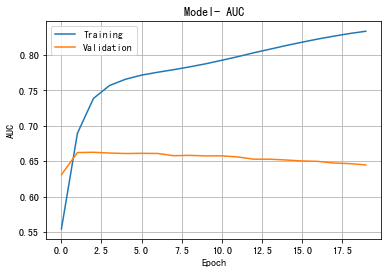

In [22]:
import matplotlib.pyplot as plt
fig2, ax_loss = plt.subplots()
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Model- AUC')
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()


In [18]:
pos_his = train_data[train_data['label']==1]
pos_his = pos_his.merge(train_shop_part,how='left',on ='门店ID')
test_group = pos_his.sort_values(by=["日期"]).groupby("用户ID")

test_history_data = pd.DataFrame(
    data={
        "user_id": list(test_group.groups.keys()),
        "shop_ids": list(test_group['门店ID'].apply(list)),
        "request_cate_ids": list(test_group['请求类目ID'].apply(list)),
        "fir_ids": list(test_group['门店一级类目'].apply(list)),
        "sec_ids": list(test_group['门店二级类目'].apply(list)),
        "thr_ids": list(test_group['门店三级类目'].apply(list)),
        "mall_ids": list(test_group['门店商圈'].apply(list)),
        "his_score": list(test_group['平均分数'].apply(list)),
        "his_price": list(test_group['price'].apply(list)),
        "his_shop_pca": list(test_group['shop_pca1'].apply(list))
        # "date": list(train_group['日期'].apply(list)),
    }
)
test_history_data['behavior_len'] = test_history_data["shop_ids"].apply(lambda x : len(x))


In [19]:
neg_his = train_data[train_data['label']==0]
neg_his = neg_his.merge(train_shop_part,how='left',on ='门店ID')
test_neg_group = neg_his.sort_values(by=["日期"]).groupby("用户ID")

test_neg_history_data = pd.DataFrame(
    data={
        "user_id": list(test_neg_group.groups.keys()),
        "neg_shop_ids": list(test_neg_group['门店ID'].apply(list)),
        "neg_request_cate_ids": list(test_neg_group['请求类目ID'].apply(list)),
        "neg_fir_ids": list(test_neg_group['门店一级类目'].apply(list)),
        "neg_sec_ids": list(test_neg_group['门店二级类目'].apply(list)),
        "neg_thr_ids": list(test_neg_group['门店三级类目'].apply(list)),
        "neg_mall_ids": list(test_neg_group['门店商圈'].apply(list)),
        "neg_his_score": list(test_neg_group['平均分数'].apply(list)),
        "neg_his_price": list(test_neg_group['price'].apply(list)),
        "neg_his_shop_pca": list(test_neg_group['shop_pca1'].apply(list)),
        # "date": list(train_group['日期'].apply(list)),
    }
)
test_neg_history_data['neg_behavior_len'] = test_neg_history_data["neg_shop_ids"].apply(lambda x : len(x))

In [20]:
test_all_data = test_context.merge(test_user_part,how='left',on='用户ID')
test_all_data = test_all_data.merge(test_shop_part,how='left',on='门店ID')
test_all_data = test_all_data.merge(test_history_data,how='left',left_on='用户ID',right_on = 'user_id')
test_all_data = test_all_data.drop('user_id',axis=1)
test_all_data = test_all_data.merge(test_neg_history_data,how='left',left_on='用户ID',right_on = 'user_id')
def fill(x):
    if x is np.nan:
        return [0,]*length
    else:
        return x
test_all_data[['shop_ids', 'request_cate_ids',
       'fir_ids', 'sec_ids', 'thr_ids', 'mall_ids', 'his_score', 'his_price',
       'his_shop_pca','neg_shop_ids', 'neg_request_cate_ids', 'neg_fir_ids', 'neg_sec_ids',
       'neg_thr_ids', 'neg_mall_ids', 'neg_his_score', 'neg_his_price', 'neg_his_shop_pca']] = test_all_data[['shop_ids', 'request_cate_ids',
       'fir_ids', 'sec_ids', 'thr_ids', 'mall_ids', 'his_score', 'his_price',
       'his_shop_pca','neg_shop_ids', 'neg_request_cate_ids', 'neg_fir_ids', 'neg_sec_ids',
       'neg_thr_ids', 'neg_mall_ids', 'neg_his_score', 'neg_his_price', 'neg_his_shop_pca']].applymap(fill)
test_all_data[['behavior_len','neg_behavior_len']] = test_all_data[['behavior_len','neg_behavior_len']].fillna(0)
test_all_data['user_id'] = test_all_data['user_id'].fillna(0)

test_all_data[['shop_ids', 'request_cate_ids',
       'fir_ids', 'sec_ids', 'thr_ids', 'mall_ids', 'his_score', 'his_price',
       'his_shop_pca','neg_shop_ids', 'neg_request_cate_ids', 'neg_fir_ids', 'neg_sec_ids',
       'neg_thr_ids', 'neg_mall_ids', 'neg_his_score', 'neg_his_price', 'neg_his_shop_pca']] = test_all_data[['shop_ids', 'request_cate_ids',
       'fir_ids', 'sec_ids', 'thr_ids', 'mall_ids', 'his_score', 'his_price',
       'his_shop_pca','neg_shop_ids', 'neg_request_cate_ids', 'neg_fir_ids', 'neg_sec_ids',
       'neg_thr_ids', 'neg_mall_ids', 'neg_his_score', 'neg_his_price', 'neg_his_shop_pca']].applymap(complement)
test_all_data[['behavior_len','neg_behavior_len']] = test_all_data[['behavior_len','neg_behavior_len']].applymap(lambda x : length if x>length else x)

In [25]:
def get_test_xy_fd(use_neg=False, hash_flag=False):
    feature_columns = [SparseFeat('user', max(test_user_part['用户ID'].max(),train_user_part['用户ID'].max())+1, embedding_dim=8, use_hash=hash_flag),
                       SparseFeat('gender', 4, embedding_dim=4, use_hash=hash_flag),
                       SparseFeat('occupation', train_user_part['职业'].max()+1, embedding_dim=4, use_hash=hash_flag),
                       SparseFeat('shop_id', max(test_shop_part['门店ID'].max(),train_shop_part['门店ID'].max()) + 1, embedding_dim=8, use_hash=hash_flag),
                       SparseFeat('request_cate_id',  max(test_context['请求类目ID'].max(),train_context['请求类目ID'].max()) + 1, embedding_dim=4, use_hash=hash_flag),
                       SparseFeat('cate_fir_id', max(test_shop_part['门店一级类目'].max(),train_shop_part['门店一级类目'].max()) + 1, embedding_dim=2, use_hash=hash_flag),
                       SparseFeat('cate_sec_id', max(test_shop_part['门店二级类目'].max(),train_shop_part['门店二级类目'].max()) + 1, embedding_dim=4, use_hash=hash_flag),
                       SparseFeat('cate_thr_id', max(test_shop_part['门店三级类目'].max(),train_shop_part['门店三级类目'].max()) + 1, embedding_dim=4, use_hash=hash_flag),
                       SparseFeat('mall_id', max(test_shop_part['门店商圈'].max(),train_shop_part['门店商圈'].max()) + 1, embedding_dim=4, use_hash=hash_flag),
                       DenseFeat('age', 1),
                      DenseFeat('user_pca1', 1),
                      DenseFeat('dis', 1),
                      DenseFeat('score', 1),
                      DenseFeat('price', 1),
                      DenseFeat('shop_pca1', 1),
                      DenseFeat('cos', 1)]

    feature_columns += [
        VarLenSparseFeat(SparseFeat('hist_shop_id', vocabulary_size=max(test_shop_part['门店ID'].max(),train_shop_part['门店ID'].max()) + 1, embedding_dim=8, embedding_name='shop_id'),
                         maxlen=length, length_name="seq_length"),
        VarLenSparseFeat(SparseFeat('hist_request_cate_id', vocabulary_size=max(test_context['请求类目ID'].max(),train_context['请求类目ID'].max()) + 1, embedding_dim=4, embedding_name='request_cate_id'),
                         maxlen=length,
                         length_name="seq_length"),
        VarLenSparseFeat(SparseFeat('hist_cate_fir_id', vocabulary_size=max(test_shop_part['门店一级类目'].max(),train_shop_part['门店一级类目'].max()) + 1, embedding_dim=2, embedding_name='cate_fir_id'),
                         maxlen=length, length_name="seq_length"),
        VarLenSparseFeat(SparseFeat('hist_cate_sec_id', vocabulary_size=max(test_shop_part['门店二级类目'].max(),train_shop_part['门店二级类目'].max()) + 1, embedding_dim=4, embedding_name='cate_sec_id'),
                         maxlen=length,length_name="seq_length"),
        VarLenSparseFeat(SparseFeat('hist_cate_thr_id', vocabulary_size=max(test_shop_part['门店三级类目'].max(),train_shop_part['门店三级类目'].max())+ 1, embedding_dim=4, embedding_name='cate_thr_id'),
                         maxlen=length,length_name="seq_length"),
        VarLenSparseFeat(SparseFeat('hist_mall_id', vocabulary_size=max(test_shop_part['门店商圈'].max(),train_shop_part['门店商圈'].max()) + 1, embedding_dim=4, embedding_name='mall_id'),
                         maxlen=length,length_name="seq_length")]
        # VarLenDenseFeat(DenseFeat('his_score', 1),
        #                  maxlen=length,length_name="seq_length"),
        # VarLenDenseFeat(DenseFeat('his_price', 1),
        #                  maxlen=length,length_name="seq_length"),
        # VarLenDenseFeat(DenseFeat('his_shop_pca', 1),
        #                  maxlen=length,length_name="seq_length")

    behavior_feature_list = ["shop_id", 
                             'request_cate_id','cate_fir_id','cate_sec_id','cate_thr_id',
                            'mall_id']

  
                        
    feature_dict = {'user': test_all_data['用户ID'].values, 
                    'gender': test_all_data['性别'].values,
                    'occupation': test_all_data['职业'].values, 
                    'age':test_all_data['年龄'].values,
                    'cos':test_all_data['cos'].values,
                    'user_pca1':test_all_data['user_pca1'].values,'dis':test_all_data['dis'].values,
                    'score':test_all_data['平均分数'].values,'price':test_all_data['price'].values,
                    'shop_pca1':test_all_data['shop_pca1'].values,
                    'shop_id': test_all_data['门店ID'].values, 'request_cate_id': test_all_data['请求类目ID'].values,
                    'cate_fir_id':test_all_data['门店一级类目'].values,'cate_sec_id': test_all_data['门店二级类目'].values,
                    'cate_thr_id': test_all_data['门店三级类目'].values,'mall_id': test_all_data['门店商圈'].values,
                    'hist_shop_id':np.array(list(test_all_data['shop_ids'].values)),'hist_request_cate_id':np.array(list(test_all_data['request_cate_ids'].values)),
                    'hist_cate_fir_id':np.array(list(test_all_data['fir_ids'].values)),'hist_cate_sec_id':np.array(list(test_all_data['sec_ids'].values)),
                    'hist_cate_thr_id':np.array(list(test_all_data['thr_ids'].values)),'hist_mall_id':np.array(list(test_all_data['mall_ids'].values)),
                    # 'his_score':train_all_data['his_score'],'his_price':train_all_data['his_price'],
                    # 'his_shop_pca':train_all_data['his_shop_pca'], 
                    "seq_length": test_all_data['behavior_len'].values}
    
    

    if use_neg:
        feature_dict['neg_hist_shop_id'] = np.array(list(test_all_data['neg_shop_ids'].values))
        feature_dict['neg_hist_request_cate_id'] = np.array(list(test_all_data['neg_request_cate_ids'].values))
        feature_dict['neg_hist_cate_fir_id'] = np.array(list(test_all_data['neg_fir_ids'].values))
        feature_dict['neg_hist_cate_sec_id'] = np.array(list(test_all_data['sec_ids'].values))
        feature_dict['neg_hist_cate_thr_id'] = np.array(list(test_all_data['thr_ids'].values))
        feature_dict['neg_hist_mall_id'] = np.array(list(test_all_data['neg_mall_ids'].values))
        feature_dict['neg_seq_length'] = test_all_data['neg_behavior_len'].values
        feature_columns += [
        VarLenSparseFeat(SparseFeat('neg_hist_shop_id', vocabulary_size=max(test_shop_part['门店ID'].max(),train_shop_part['门店ID'].max()) + 1, embedding_dim=8, embedding_name='shop_id'),
                         maxlen=length, length_name="neg_seq_length"),
        VarLenSparseFeat(SparseFeat('neg_hist_request_cate_id', vocabulary_size=max(test_context['请求类目ID'].max(),train_context['请求类目ID'].max()) + 1, embedding_dim=4, embedding_name='request_cate_id'),
                         maxlen=length,
                         length_name="neg_seq_length"),
        VarLenSparseFeat(SparseFeat('neg_hist_cate_fir_id', vocabulary_size=max(test_shop_part['门店一级类目'].max(),train_shop_part['门店一级类目'].max()) + 1, embedding_dim=2, embedding_name='cate_fir_id'),
                         maxlen=length, length_name="neg_seq_length"),
        VarLenSparseFeat(SparseFeat('neg_hist_cate_sec_id', vocabulary_size=max(test_shop_part['门店二级类目'].max(),train_shop_part['门店二级类目'].max()) + 1, embedding_dim=4, embedding_name='cate_sec_id'),
                         maxlen=length,length_name="neg_seq_length"),
        VarLenSparseFeat(SparseFeat('neg_hist_cate_thr_id', vocabulary_size=max(test_shop_part['门店三级类目'].max(),train_shop_part['门店三级类目'].max())+ 1, embedding_dim=4, embedding_name='cate_thr_id'),
                         maxlen=length,length_name="neg_seq_length"),
        VarLenSparseFeat(SparseFeat('neg_hist_mall_id', vocabulary_size=max(test_shop_part['门店商圈'].max(),train_shop_part['门店商圈'].max()) + 1, embedding_dim=4, embedding_name='mall_id'),
                         maxlen=length,length_name="neg_seq_length")]

    x = {name: feature_dict[name] for name in get_feature_names(feature_columns)}
    
    # print(x)
    # print(feature_columns)
    # y = train_all_data['label'].values
    return x

test_x= get_test_xy_fd(use_neg=True)
y_pred = model.predict(test_x)

In [27]:
result = pd.DataFrame()
result['re'] = (y_pred>=0.5).astype('int').flatten()
result.to_csv('result/out_cos_2.csv',header=None)

In [26]:
(y_pred>0.5).astype('int').flatten().sum()

174696

In [ ]:
!pip install -U deepctr-torch

In [ ]:
import tensorflow as tf



# Config
print(tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

In [ ]:
np.array([[1, 2, 3, 0], [1, 2, 3, 0], [1, 2, 0, 0], [1, 2, 0, 0]])

In [ ]:
train_target.label.sum()